# LendingClub Loan Default & Interest Rate Prediction

#Background
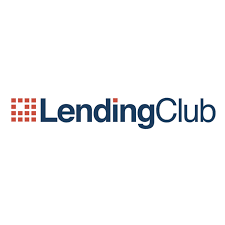

LendingClub,is a trailblazer in the U.S. peer-to-peer lending industry, notable for being the first such company to register its offerings with the SEC and to facilitate loan trading on a secondary market. In this project, we leverages this rich context by supervised learning models to predict potential loan defaults and determine appropriate interest rates for loans issued through LendingClub's online platform. By predicting default probabilities and interest rates, the project aims to enhance risk management and pricing strategies, thus supporting LendingClub's mission to provide a secure and efficient lending environment for borrowers and investors alike.

# Part 0: Setup Google Drive Environment & Load Data



In [ ]:
import pandas as pd
import numpy as np

from tabulate import tabulate


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# correlation heat map of numerical features
import seaborn as sns
import matplotlib.pyplot as plt

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1VOAhrB5eIhFc8C5qeFx5QYa2OLD7s1eV'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id})
file.GetContentFile('loan-clean-version.csv')
df  = pd.read_csv('loan-clean-version.csv')


# Part 1: Data Exploration

#1.1 Understand the Raw Dataset

We will focus on default and interest rate predictions for small loans up to $35k. Currently, the interest rate is right-skewed with capped by 25% .

The default rate and losses of these small loans were relatively high, with 17% of the loans having defaulted and 43% of losses on these defaulted loans. Thus, it is essential for the company to enhance small loan's default management and pricing strategies to boost its profitability.

We have a dataset consisting of 9,004 records and 29 features for deeper analysis. Out of these 29 features, 21 are numeric. Only two features, *emp_length* and *revol_util*, have missing values.

<Axes: title={'center': 'Distribution of Interest Rates'}, ylabel='Frequency'>

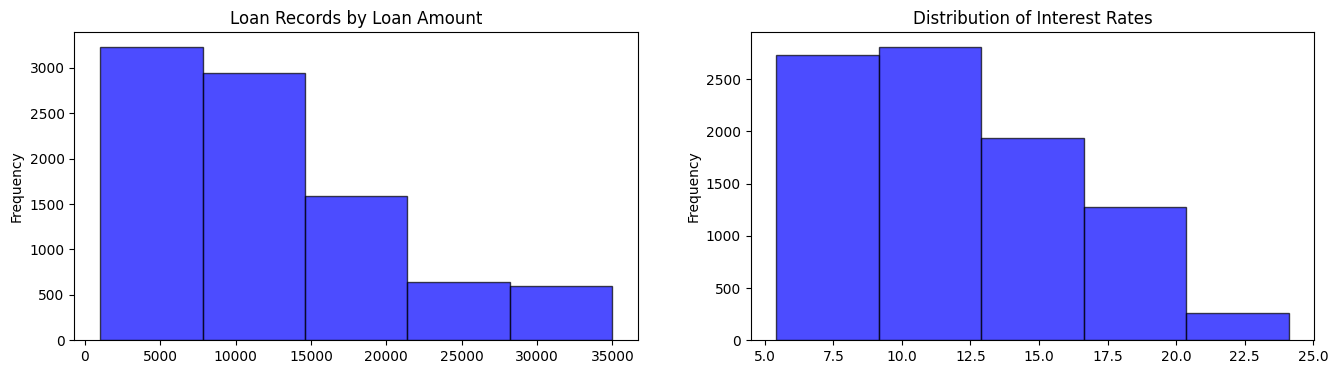

In [ ]:
fig,axss = plt.subplots(1,2, figsize=[16,4])
df["loan_amnt"].plot(kind='hist', bins=5, color = 'blue', edgecolor='black', alpha=0.7,title = 'Loan Records by Loan Amount', ax = axss[0])
df["int_rate"].plot(kind='hist', bins=5, color = 'blue', edgecolor='black', alpha=0.7,title = 'Distribution of Interest Rates', ax = axss[1])

In [ ]:
# check the distribution of target variable1 loan_status
round(df['loan_status'].value_counts(normalize=True),2)

loan_status
Fully Paid     0.83
Charged Off    0.17
Name: proportion, dtype: float64

In [ ]:
# get the % of loss by default
round(1 - sum(df['total_pymnt'][df['loan_status']=='Charged Off'])/sum(df['funded_amnt'][df['loan_status']=='Charged Off']),2)

0.43

In [ ]:
# check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9004 entries, 0 to 9003
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   9004 non-null   int64  
 1   loan_amnt            9004 non-null   int64  
 2   funded_amnt          9004 non-null   int64  
 3   funded_amnt_inv      9004 non-null   float64
 4   term                 9004 non-null   object 
 5   int_rate             9004 non-null   float64
 6   installment          9004 non-null   float64
 7   grade                9004 non-null   object 
 8   emp_length           8688 non-null   object 
 9   home_ownership       9004 non-null   object 
 10  annual_inc           9004 non-null   float64
 11  verification_status  9004 non-null   object 
 12  purpose              9004 non-null   object 
 13  addr_state           9004 non-null   object 
 14  dti                  9004 non-null   float64
 15  earliest_cr_line     9004 non-null   i

In [ ]:
# check missing values
df.isnull().sum()[df.isnull().sum() > 0]

emp_length    316
revol_util      3
dtype: int64

#1.2 EDA



In this session, we will focus on exploratory data analysis to gain a deeper understanding of this dataset. We will identify potential data errors, missing values, outliers, and explore correlations between features. This analysis will inform our subsequent data cleaning and processing steps, ultimately enhancing our modeling efforts.

###1.2.1 Basic Descriptive Analysis

####Loan Purpose
Most of loans approved were used for debt consolidation and credit card. 50% of the loans were for debt consolidation.

Default rates showed significant volatility. Small businesses experienced a notably high default rate, while loans for major purchases had a lower default rate. Conversely, interest rates showed relatively minor variations across different loan purposes.

In [ ]:
#encode default vs not default
df['loan_status'] = [1 if i == 'Charged Off' else 0  for i in df['loan_status'] ]
# recode emp_length
def recode_purpose(p):
    if p == 'renewable_energy' or p == 'vacation' or p == 'wedding':
        return 'other'
    elif p == 'house' or p == 'moving' or p == 'home_improvement':
        return 'house'
    else:
        return p

df['purpose'] = df['purpose'].apply(recode_purpose)

Text(0, 0.5, 'Purpose')

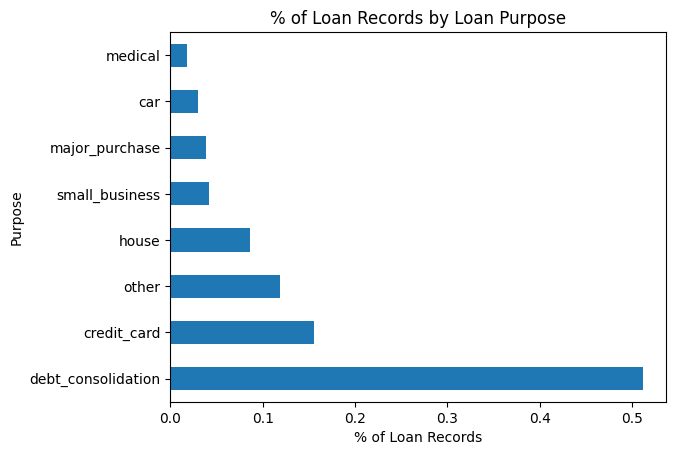

In [ ]:
# explore purpose category
axp0 = df['purpose'].value_counts(normalize=True).plot(kind = 'barh',title = '% of Loan Records by Loan Purpose')
axp0.set_xlabel('% of Loan Records')
axp0.set_ylabel('Purpose')

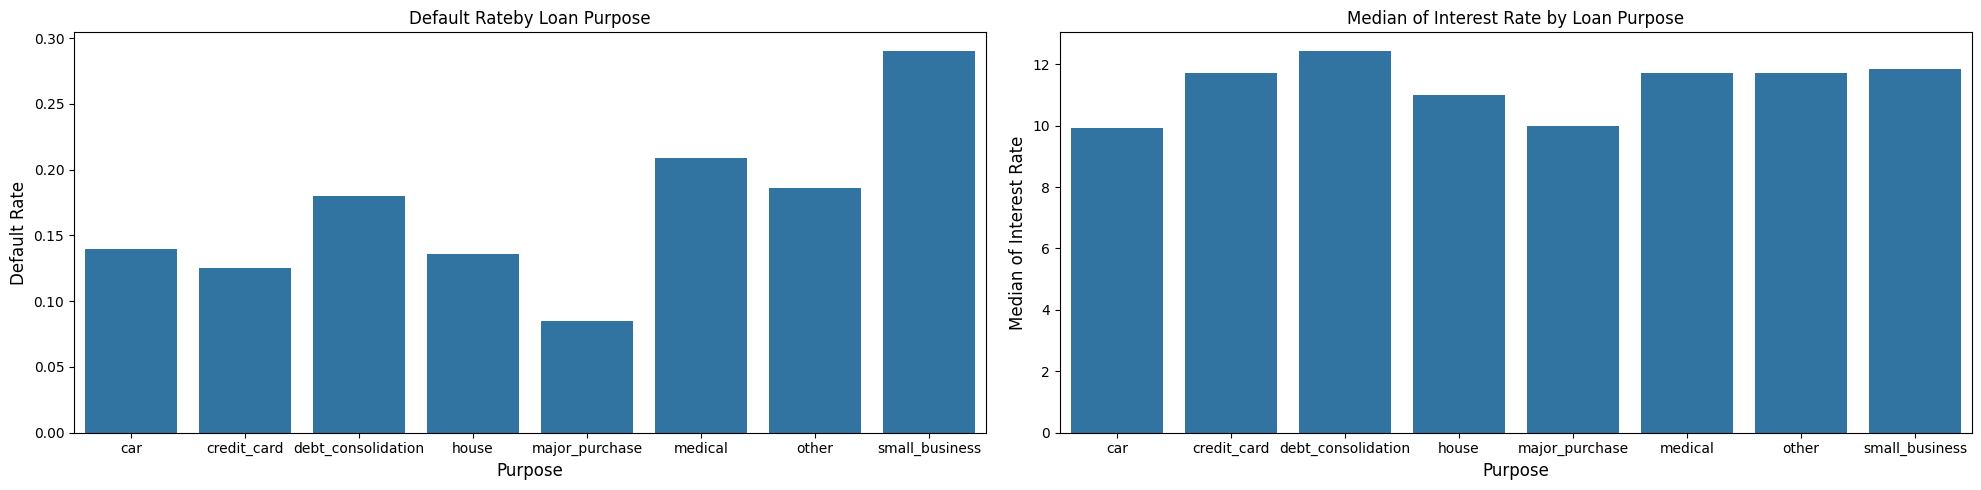

In [ ]:
fig,axp = plt.subplots(1,2, figsize=[20,5])
# Group by category and calculate the default rate
avg_loan_status = df.groupby('purpose')['loan_status'].mean().reset_index()

# default rate vs purpose
sns.barplot(x = 'purpose', y ='loan_status', data=avg_loan_status,ax = axp[0])
axp[0].set_title('Default Rateby Loan Purpose')
axp[0].set_xlabel('Purpose', fontsize=12)
axp[0].set_ylabel('Default Rate', fontsize=12)

# Group by category and calculate the interest rate
avg_loan_status = df.groupby('purpose')['int_rate'].median().reset_index()

# Create the barplot on the appropriate subplot
sns.barplot(x = 'purpose', y ='int_rate', data=avg_loan_status, ax= axp[1])
axp[1].set_title('Median of Interest Rate by Loan Purpose')
axp[1].set_xlabel('Purpose', fontsize=12)
axp[1].set_ylabel('Median of Interest Rate', fontsize=12)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

#### Loan Term
70% of loans inssued were 36 months. 60-month loans had higher default rate and interest rate than 36-month loans.

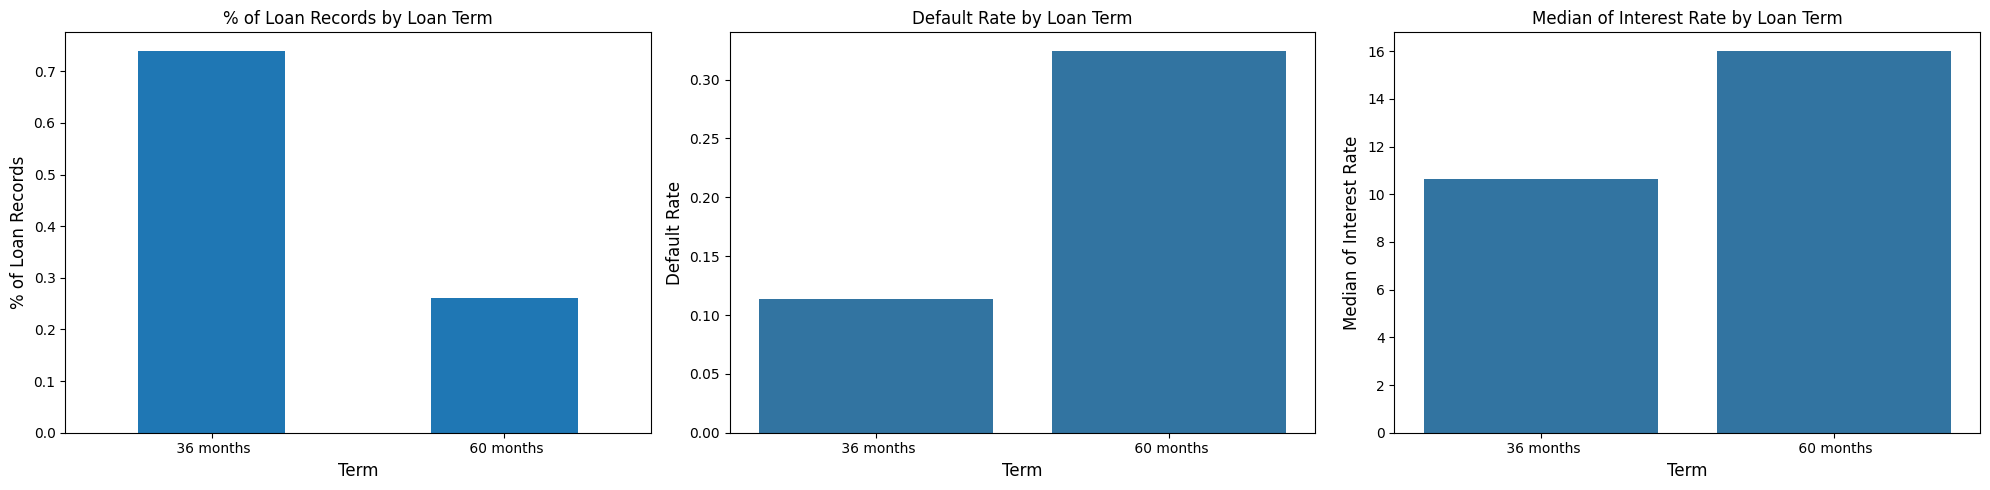

In [ ]:

fig,axp = plt.subplots(1,3, figsize=[20,5])

# % of loan records by term
df['term'].value_counts(normalize=True).plot(kind = 'bar',title = '% of Loan Records by Loan Term', ax = axp[0])
axp[0].set_ylabel('% of Loan Records', fontsize=12)
axp[0].set_xlabel('Term', fontsize=12, rotation=0)
axp[0].set_xlabel('Term', fontsize=12, rotation=0)
axp[0].tick_params(labelrotation=0)

# default rate vs term
avg_loan_status = df.groupby('term')['loan_status'].mean().reset_index()
sns.barplot(x = 'term', y ='loan_status', data=avg_loan_status,ax = axp[1])
axp[1].set_title('Default Rate by Loan Term')
axp[1].set_xlabel('Term', fontsize=12)
axp[1].set_ylabel('Default Rate', fontsize=12)

# interest rate vs term
avg_loan_status = df.groupby('term')['int_rate'].median().reset_index()
sns.barplot(x = 'term', y ='int_rate', data=avg_loan_status, ax= axp[2])
axp[2].set_title('Median of Interest Rate by Loan Term')
axp[2].set_xlabel('Term', fontsize=12)
axp[2].set_ylabel('Median of Interest Rate', fontsize=12)

# Adjust the spacing between subplots
plt.tight_layout()


# Show the plot
plt.show()


#### Grade

As expected, default rate and interest rate increased as borrower's grade decreased.

The company was aggressive in issuing the loans,with the 40% of the loans granted to borrowers rated <= Grade C and the company issued nearly 100% of the loans the borrowers applied even to borrowers rated <= Grade C, which might lead a high default rate.

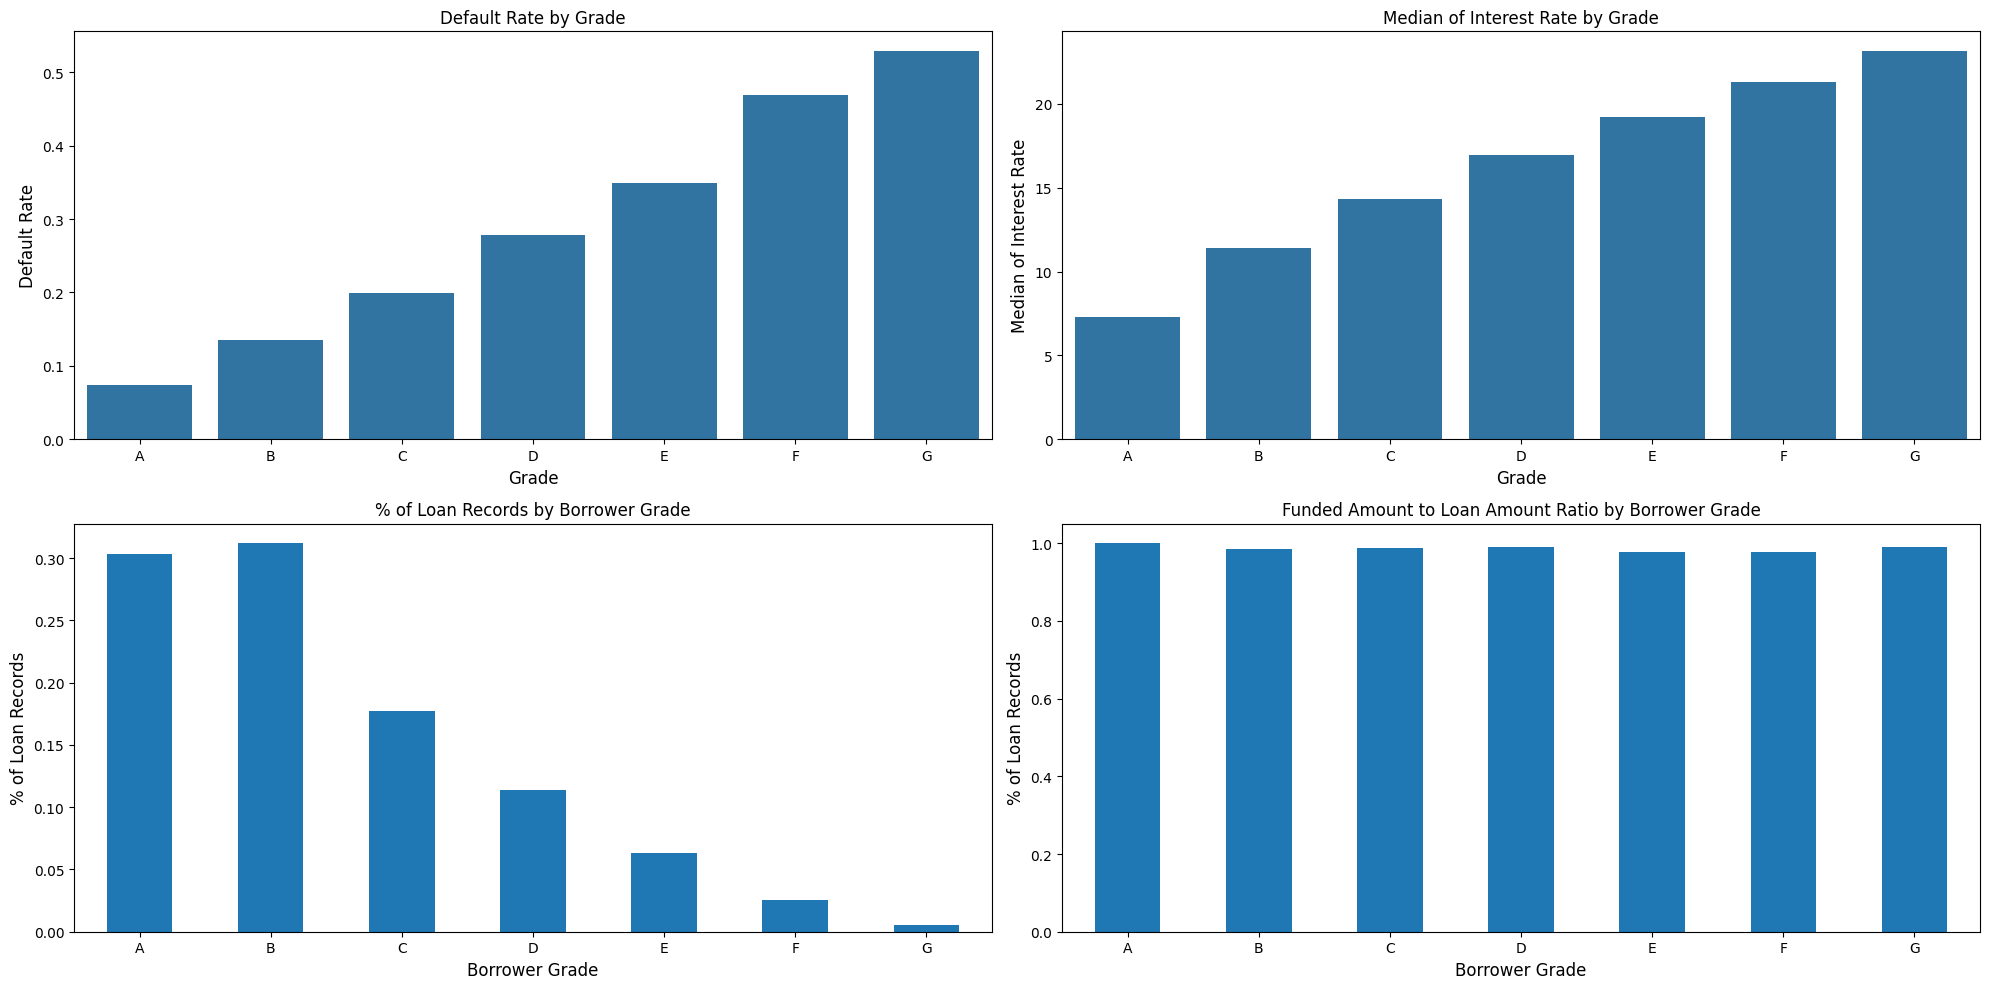

<Figure size 640x480 with 0 Axes>

In [ ]:
# prompt: get default rate and interest rate vs grade

fig,axp = plt.subplots(2,2, figsize=[20,10])
fig.subplots_adjust(hspace=0.5)

# default rate vs grade
avg_loan_status = df.groupby('grade')['loan_status'].mean().reset_index()
sns.barplot(x = 'grade', y ='loan_status', data=avg_loan_status,ax = axp[0,0])
axp[0,0].set_title('Default Rate by Grade')
axp[0,0].set_xlabel('Grade', fontsize=12)
axp[0,0].set_ylabel('Default Rate', fontsize=12)

# interest rate vs grade
avg_loan_status = df.groupby('grade')['int_rate'].mean().reset_index()
sns.barplot(x = 'grade', y ='int_rate', data=avg_loan_status, ax= axp[0,1])
axp[0,1].set_title('Median of Interest Rate by Grade')
axp[0,1].set_xlabel('Grade', fontsize=12)
axp[0,1].set_ylabel('Median of Interest Rate', fontsize=12)

df["grade"].value_counts(normalize=True).sort_index().plot(kind='bar', ax = axp[1,0])

# Calculate the ratio of sums
grouped = df.groupby('grade').sum()
grouped['ratio'] = grouped['funded_amnt'] / grouped['loan_amnt']

# Plotting the ratios
grouped['ratio'].plot(kind='bar')
axp[1,0].set_title('% of Loan Records by Borrower Grade')
axp[1,0].set_xlabel('Borrower Grade', fontsize=12)
axp[1,0].set_ylabel('% of Loan Records', fontsize=12)
axp[1,0].tick_params(labelrotation=0)

axp[1,1].set_title('Funded Amount to Loan Amount Ratio by Borrower Grade')
axp[1,1].set_xlabel('Borrower Grade', fontsize=12)
axp[1,1].set_ylabel('% of Loan Records', fontsize=12)
axp[1,1].tick_params(labelrotation=0)

plt.tight_layout()
plt.show()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


#### Employment Length & Home Ownership
Most borrowers had fewer than 10 years of employment, which explains the low homeownership among them. However, neither the length of employment nor homeownership status significantly influenced default rates or interest rates.

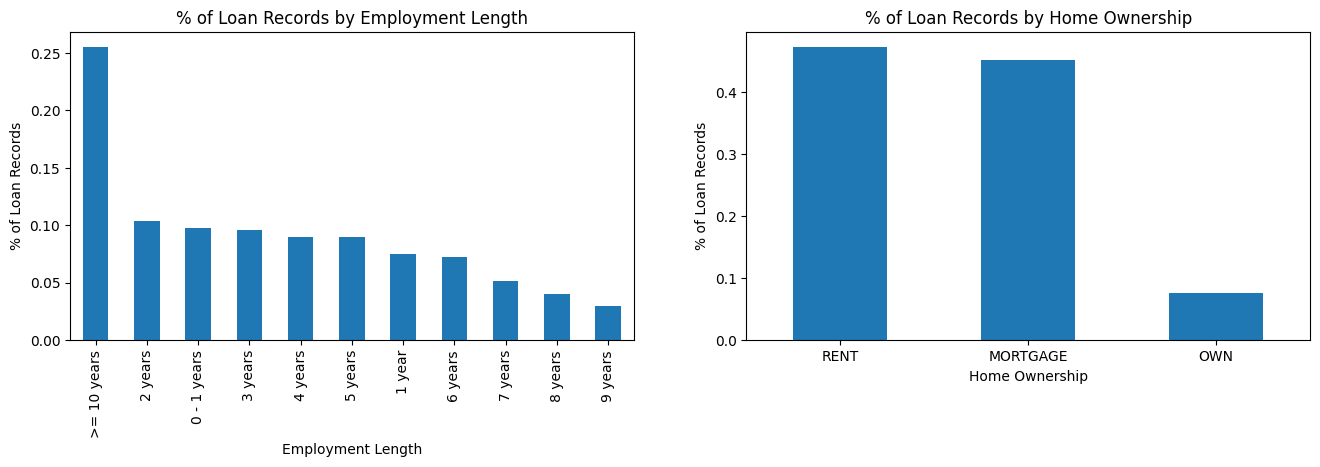

In [ ]:
# recode emp_length
def recode_emp_length(el):
    if el == 'Less than 1 year':
        return '0 - 1 years'
    elif el == '10+ years':
        return '>= 10 years'
    else:
        return el

df['emp_length'] = df['emp_length'].apply(recode_emp_length)
# explore home ownership & emp_length category
fig,axss = plt.subplots(1,2, figsize=[16,4])
df["emp_length"].value_counts(normalize=True).plot(kind='bar',title = '% of Loan Records by Employment Length', ax=axss[0])
df["home_ownership"].value_counts(normalize=True).plot(kind='bar', title = '% of Loan Records by Home Ownership', ax=axss[1])

#set axis labels
axss[0].set_xlabel('Employment Length')
axss[0].set_ylabel('% of Loan Records')

axss[1].set_xlabel('Home Ownership')
axss[1].set_ylabel('% of Loan Records')
axss[1].tick_params(labelrotation=0)

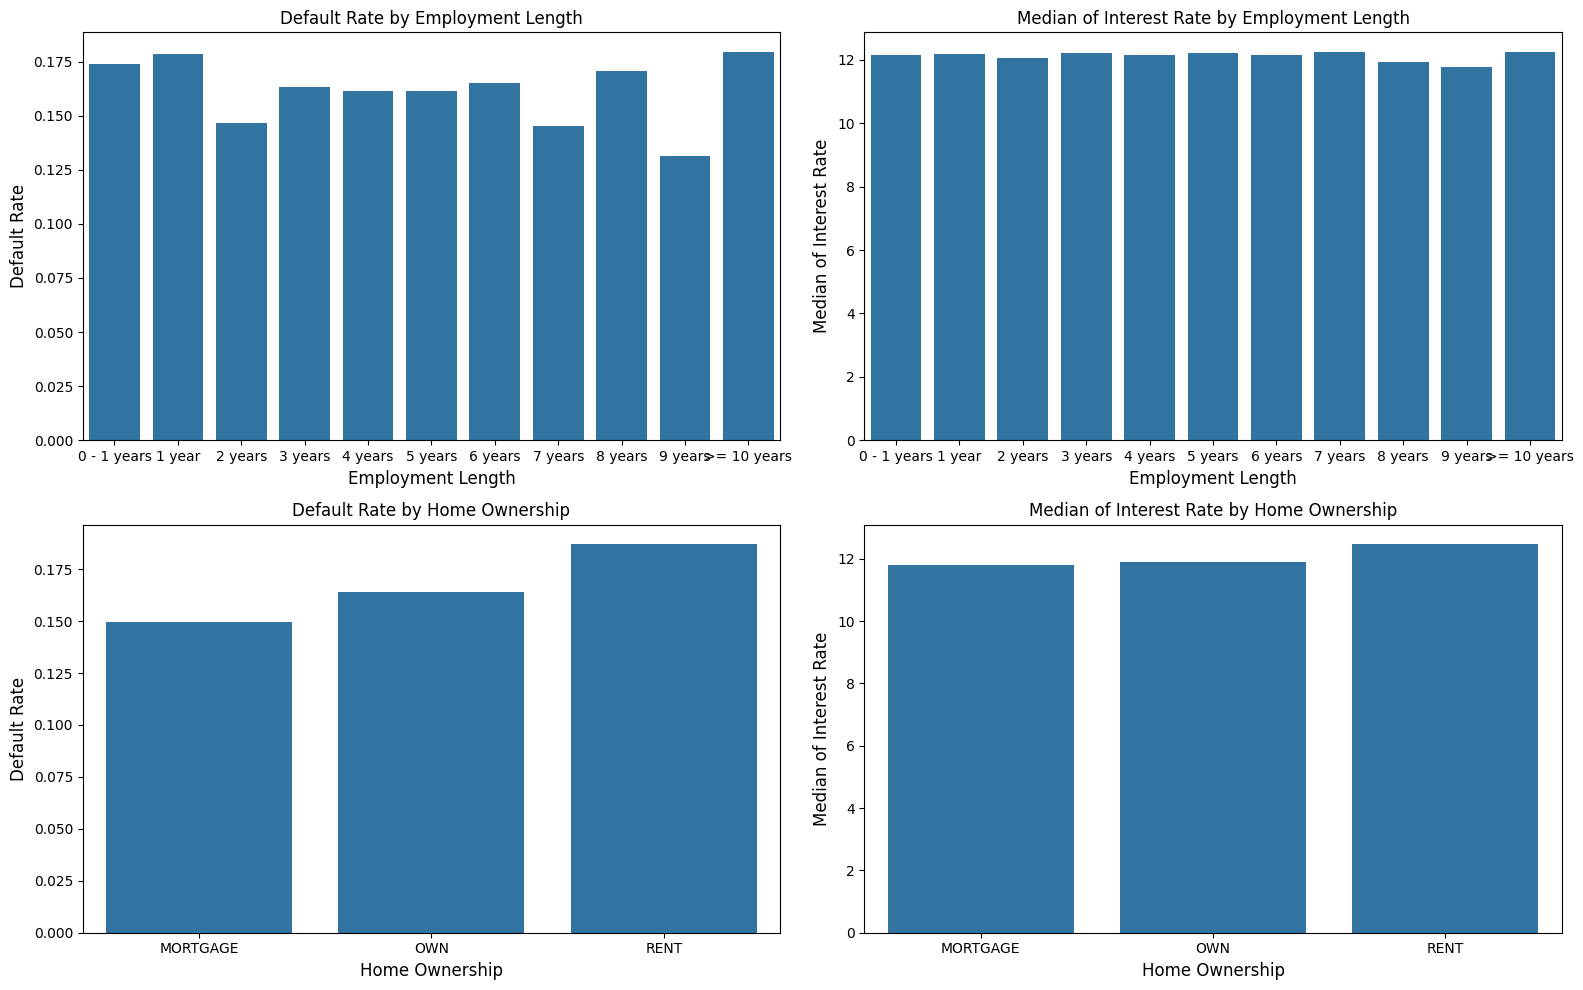

In [ ]:
fig,axss = plt.subplots(2,2, figsize=[16,10])
fig.subplots_adjust(hspace=0.4)
# Group by category and calculate the default rate
avg_loan_status = df.groupby('emp_length')['loan_status'].mean().reset_index()

# default rate vs emp_length
sns.barplot(x = 'emp_length', y ='loan_status', data=avg_loan_status,ax = axss[0,0])
axss[0,0].set_title('Default Rate by Employment Length')
axss[0,0].set_xlabel('Employment Length', fontsize=12)
axss[0,0].set_ylabel('Default Rate', fontsize=12)

# Group by category and calculate the interest rate
avg_loan_status = df.groupby('emp_length')['int_rate'].mean().reset_index()

# Create the barplot on the appropriate subplot
sns.barplot(x = 'emp_length', y ='int_rate', data=avg_loan_status, ax= axss[0,1])
axss[0,1].set_title('Median of Interest Rate by Employment Length')
axss[0,1].set_xlabel('Employment Length', fontsize=12)
axss[0,1].set_ylabel('Median of Interest Rate', fontsize=12)

# Group by category and calculate the default rate
avg_loan_status = df.groupby('home_ownership')['loan_status'].mean().reset_index()

# default rate vs home_ownership
sns.barplot(x = 'home_ownership', y ='loan_status', data=avg_loan_status,ax = axss[1,0])
axss[1,0].set_title('Default Rate by Home Ownership')
axss[1,0].set_xlabel('Home Ownership', fontsize=12)
axss[1,0].set_ylabel('Default Rate', fontsize=12)

# Group by category and calculate the interest rate
avg_loan_status = df.groupby('home_ownership')['int_rate'].mean().reset_index()

# Create the barplot on the appropriate subplot
sns.barplot(x = 'home_ownership', y ='int_rate', data=avg_loan_status, ax= axss[1,1])
axss[1,1].set_title('Median of Interest Rate by Home Ownership')
axss[1,1].set_xlabel('Home Ownership', fontsize=12)
axss[1,1].set_ylabel('Median of Interest Rate', fontsize=12)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


#### Borrower Solvency
The DTI limit of 30% implied borrowers should have sufficient income to cover LC installment. However, with over 50% of borrowers using 50% or more of their credit, this high Revolving Line Utilization Rate mirrored the borrowers' overspending, which might also contribute to the LC's high default rate.


Text(0, 0.5, 'Loan Records')

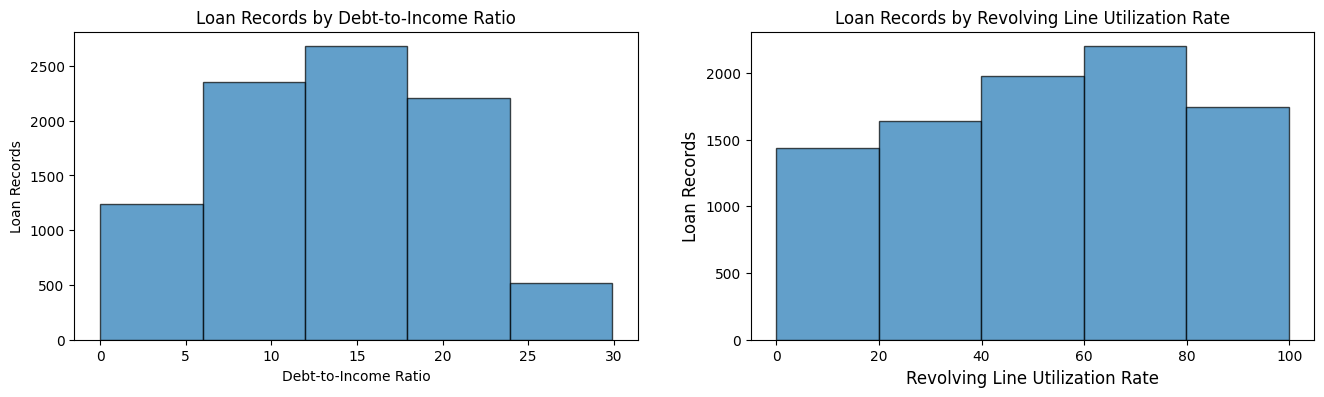

In [ ]:
fig,axss = plt.subplots(1,2, figsize=[16,4])

#records by dti range
df["dti"].plot(kind='hist', bins=5, edgecolor='black', alpha=0.7,title = 'Loan Records by Debt-to-Income Ratio', ax = axss[0])
#set axis labels
axss[0].set_xlabel('Debt-to-Income Ratio')
axss[0].set_ylabel('Loan Records')


#records by revol_util range
df["revol_util"].plot(kind='hist', bins=5, edgecolor='black', alpha=0.7,title = 'Loan Records by Revolving Line Utilization Rate', ax = axss[1])
axss[1].set_title('Loan Records by Revolving Line Utilization Rate')
axss[1].set_xlabel('Revolving Line Utilization Rate', fontsize=12)
axss[1].set_ylabel('Loan Records', fontsize=12)

#### Borrower Location
The borrower's location did not significantly influence default rates and interest rates. In some states, the extremely high or low values observed in default and interest rates could be due to randomness, especially in states with fewer loan records.

In [ ]:
import plotly.graph_objects as go

# Prepare the data for total loans issued by state
df_total_loans = df.groupby("addr_state").count().reset_index()
df_total_loans = df_total_loans[['addr_state', 'loan_amnt']]
# Create the choropleth map
fig = go.Figure(data=go.Choropleth(
    locations=df_total_loans['addr_state'],  # Spatial coordinates
    z=df_total_loans['loan_amnt'].astype(float),  # Data to be color-coded
    locationmode='USA-states',  # Set of locations match entries in `locations`
    colorscale='Reds',
    colorbar_title="Counts",
))

# Update the layout for a better visual presentation
fig.update_layout(
    title_text='Total Loans Issued by State',
    geo_scope='usa',  # Limit map scope to USA
    width=800,  # Width of the figure in pixels
    height=500  # Height of the figure in pixels
)

# Show the figure
fig.show()

In [ ]:

from plotly.subplots import make_subplots
# Prepare the data for default rate by state
df_default = df.filter(["addr_state", "loan_status"], axis=1)
df_default_rate = df_default.groupby("addr_state").mean().reset_index()

# Prepare the data for interest rate by state
df_interest_rate = df.filter(["addr_state", "int_rate"], axis=1).groupby("addr_state").mean().reset_index()


# Create subplots with geographic subplot types
fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{'type': 'geo'}, {'type': 'geo'}]],  # Correct specification for geo subplots
    subplot_titles=("Default Rate by State", "Interest Rate by State"),
    horizontal_spacing=0.05  # Adjusts spacing between plots
)

# Map 1: Default Rate
fig.add_trace(
    go.Choropleth(
        locations=df_default_rate['addr_state'],
        z=df_default_rate['loan_status'].astype(float),
        locationmode='USA-states',
        colorscale='Reds',
        colorbar_title="Default Rate",
        colorbar=dict(x=0.45)  # Adjust the position of the colorbar for this plot
    ),
    row=1, col=1
)

# Map 2: Interest Rate
fig.add_trace(
    go.Choropleth(
        locations=df_interest_rate['addr_state'],
        z=df_interest_rate['int_rate'].astype(float),
        locationmode='USA-states',
        colorscale='Cividis',
        colorbar_title="Interest Rate",
        colorbar=dict(x=0.95)  # Adjust the position of the colorbar for this plot
    ),
    row=1, col=2
)

# Update layout for each geo subplot to focus on the USA
for i in range(1, 3):
    fig.update_geos(
        row=1, col=i,
        visible=True,
        resolution=50,
        showcoastlines=True,
        coastlinecolor="RebeccaPurple",
        showland=True,
        landcolor="LightGrey",
        countrycolor="RebeccaPurple",
        showcountries=True,
        countrywidth=0.5,
        scope='usa'
    )

# Update the main layout to fit the subplots neatly
fig.update_layout(
    title_text="Loan Statistics by State",
    width=1400,  # width of the figure in pixels
    height=500  # height of the figure in pixels
)

fig.show()

### 1.2.2 Correlation Analysis

From our initial data exploration, we identified that loan purpose, loan term, borrower grade, default rate, and revolving line utilization rate can influence borrower defaults and interest rates. In this session, we will conduct a correlation analysis to further investigate the relationships between these metrics.

#### Correlation Between Categorical Variables

 Loan term, borrower grade, home ownership status, verification status, and loan purpose and borrower location and derogatory public records were correlated with borrower default.

In [ ]:
# recode addr_state, only keep states with top 5 loans issued
def recode_addr(s):
    if s in ['CA','NY','FL','TX','NJ']:
        return s
    else:
        return 'Others'

df['addr_state'] = df['addr_state'].apply(recode_addr)

In [ ]:
# chi square test between catgorical varaibles
import pandas as pd
from scipy.stats import chi2_contingency

cols = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose','pub_rec','addr_state']

for col in cols:
  crosstab = pd.crosstab(df[col], df['loan_status'])
  chi2, p, dof, expected = chi2_contingency(crosstab)
  if p < 0.05:
    print(f"{col} and loan_status are correlated (p = {p:.4f})")



term and loan_status are correlated (p = 0.0000)
grade and loan_status are correlated (p = 0.0000)
home_ownership and loan_status are correlated (p = 0.0000)
verification_status and loan_status are correlated (p = 0.0000)
purpose and loan_status are correlated (p = 0.0000)
pub_rec and loan_status are correlated (p = 0.0000)
addr_state and loan_status are correlated (p = 0.0473)


#### Categorical Variables vs Numeric Variables

Loan amount, funded amount, funded amount from investor, interest rate, installment, dti, borrower’s earliest reported credit line,recent 6 month inquiries,derogatory public records and revolving line utilization rate would influence borrower default.

Loan term, loan grade,home ownership, verification status, loan purpose and derogatory public records would influence borrower's interest rate.



In [ ]:
numcol = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate','installment', 'annual_inc','dti','earliest_cr_line', 'inq_last_6mths',
          'open_acc', 'revol_bal', 'revol_util', 'total_acc']
for col2 in numcol:
  crosstab = pd.crosstab(df['loan_status'], pd.cut(df[col2], 5))
  chi2, p, dof, expected = chi2_contingency(crosstab)
  if p < 0.05:
    print(f"loan_status and {col2} are correlated (p = {p:.4f})")



loan_status and loan_amnt are correlated (p = 0.0000)
loan_status and funded_amnt are correlated (p = 0.0000)
loan_status and funded_amnt_inv are correlated (p = 0.0000)
loan_status and int_rate are correlated (p = 0.0000)
loan_status and installment are correlated (p = 0.0000)
loan_status and dti are correlated (p = 0.0000)
loan_status and earliest_cr_line are correlated (p = 0.0436)
loan_status and inq_last_6mths are correlated (p = 0.0000)
loan_status and revol_util are correlated (p = 0.0000)


In [ ]:
catcol = df[['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose','loan_status','pub_rec','addr_state']]

for col1 in catcol:
   crosstab = pd.crosstab(df[col1], pd.cut(df['int_rate'], 5))
   chi2, p, dof, expected = chi2_contingency(crosstab)
   if p < 0.05:
    print(f"{col1} and {col2} are correlated (p = {p:.4f})")

term and total_acc are correlated (p = 0.0000)
grade and total_acc are correlated (p = 0.0000)
home_ownership and total_acc are correlated (p = 0.0000)
verification_status and total_acc are correlated (p = 0.0000)
purpose and total_acc are correlated (p = 0.0000)
loan_status and total_acc are correlated (p = 0.0000)
pub_rec and total_acc are correlated (p = 0.0000)


#### Correlation Analysis Between Numeric Variables

For this analysis, we excluded variables total_pymnt , total_pymnt_inv, total_rec_prncp, total_rec_int since this information would be unavailable at the time of predicting whether a borrower would default and when calculating the interest rate. Besides, we did not consider variable out_prncp & out_prncp_inv since they were all 0s. id was also excluded since it would not contribute to default and interest rate prediction.

None of these numeric variables appeared to have a strong linear correlation with interest rate individually since all correlation coefficients were less than 0.5. Loan amount, funded amount, funded amount from investor,and installment had mild linear correlation with interest rate.

Variables loan amount, funded amount, funded amount from investor,and installment were super highly correlated with each other since funded amount, funded amount from investor and installment were largely determined by loan amount.

In [ ]:
df.drop(['out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','id'], axis = 1 ,inplace = True)

In [ ]:
# get correlationship between numeric variables

pd.set_option('display.precision', 4)
corr = df[numcol].corr()

In [ ]:
corr

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,earliest_cr_line,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc
loan_amnt,1.0000,0.9911,0.9886,0.3084,0.9452,0.3748,0.0268,-0.2085,0.0311,0.1659,0.3292,0.0202,0.2662
funded_amnt,0.9911,1.0000,0.9977,0.3034,0.9598,0.3735,0.0256,-0.2047,0.0344,0.1661,0.3275,0.0211,0.2636
funded_amnt_inv,0.9886,0.9977,1.0000,0.3029,0.9592,0.3716,0.0252,-0.2040,0.0362,0.1655,0.3254,0.0224,0.2617
int_rate,0.3084,0.3034,0.3029,1.0000,0.2679,0.0761,0.0916,0.1062,0.1995,0.0385,0.1022,0.4709,-0.0149
installment,0.9452,0.9598,0.9592,0.2679,1.0000,0.3852,0.0175,-0.1818,0.0307,0.1638,0.3257,0.0565,0.2432
annual_inc,0.3748,0.3735,0.3716,0.0761,0.3852,1.0000,-0.1769,-0.2457,0.0482,0.2026,0.3693,-0.0053,0.3191
dti,0.0268,0.0256,0.0252,0.0916,0.0175,-0.1769,1.0000,-0.0468,0.0252,0.2859,0.2133,0.2435,0.2242
earliest_cr_line,-0.2085,-0.2047,-0.2040,0.1062,-0.1818,-0.2457,-0.0468,1.0000,-0.0104,-0.2004,-0.2789,0.0538,-0.4002
inq_last_6mths,0.0311,0.0344,0.0362,0.1995,0.0307,0.0482,0.0252,-0.0104,1.0000,0.1075,-0.0273,-0.0585,0.1259
open_acc,0.1659,0.1661,0.1655,0.0385,0.1638,0.2026,0.2859,-0.2004,0.1075,1.0000,0.2766,-0.1034,0.6741


[Text(0.5, 0, 'loan_amnt'),
 Text(1.5, 0, 'funded_amnt'),
 Text(2.5, 0, 'funded_amnt_inv'),
 Text(3.5, 0, 'int_rate'),
 Text(4.5, 0, 'installment'),
 Text(5.5, 0, 'annual_inc'),
 Text(6.5, 0, 'dti'),
 Text(7.5, 0, 'earliest_cr_line'),
 Text(8.5, 0, 'inq_last_6mths'),
 Text(9.5, 0, 'open_acc'),
 Text(10.5, 0, 'revol_bal'),
 Text(11.5, 0, 'revol_util'),
 Text(12.5, 0, 'total_acc')]

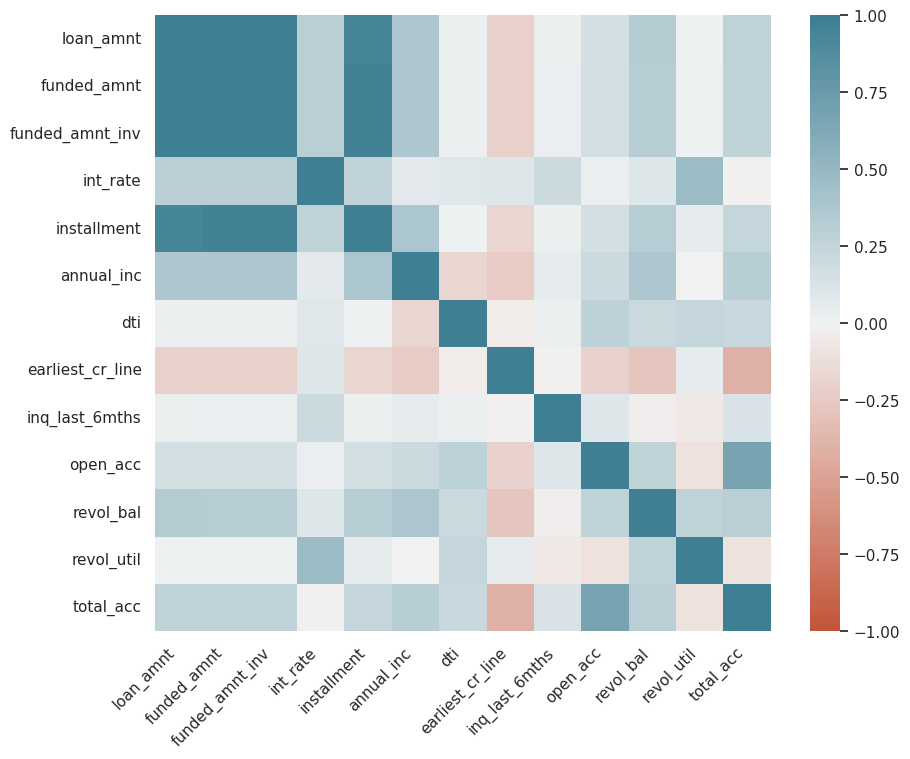

In [ ]:
sns.set()

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')

#### Summary
Most of the variables were correlated with borrower default and interest rate, which ensures the feasibility of predicting borrower default and interest rate using these variables.

### 1.2.3 Outlier Detection

In this session, we will validate the data to identify outliers and investigate the causes of these unusual values.

We excluded funded amount, funded amount from investor,and installment since they were highly correlated with loan amount.

In [ ]:
df = df.drop(['funded_amnt', 'funded_amnt_inv','installment'], axis = 1)


For  interest rate,DTI, recent 6-month inqueries , and derogatory public records, the difference between min vs 5th percentile and max vs 95th percentile was small so there variables had no outlier.

In [ ]:
df.drop(['loan_status','pub_rec'],axis = 1).describe(percentiles=[0.05,0.5,0.95])

,loan_amnt,int_rate,annual_inc,dti,earliest_cr_line,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc
count,9004.0000,9004.0000,9.0040e+03,9004.00,9004.0000,9004.0000,9004.0000,9004.0000,9001.0000,9004.0000
mean,12291.8842,12.1267,6.9577e+04,13.89,37300.4628,0.8572,9.4298,13658.4161,52.3688,22.4386
std,8285.6822,4.1957,4.8858e+04,6.61,4379.6522,1.0440,4.2638,15038.8254,27.6448,11.1465
min,1000.0000,5.4200,6.0000e+03,0.00,19998.0000,0.0000,2.0000,0.0000,0.0000,3.0000
5%,2500.0000,6.0300,2.5000e+04,2.97,30742.0000,0.0000,4.0000,613.2000,4.3000,7.0000
50%,10000.0000,11.7100,6.0000e+04,13.94,36161.0000,1.0000,9.0000,9889.0000,54.7000,21.0000
95%,30000.0000,19.4200,1.4700e+05,24.20,43040.0000,3.0000,17.0000,38496.6500,93.8000,43.0000
max,35000.0000,24.1100,1.7820e+06,29.92,43076.0000,8.0000,34.0000,148804.0000,99.9000,79.0000


For the rest numeric variable, we considered values that fall more than 3 standard deviations away from the mean, either above or below, to be outliers.

Annual income,open credit lines, total credit revolving balance and total credit lines had outliers. Total credit revolving balance had more outliers, with 2% of values were outliers.

In [ ]:
def get_outlier_record(column):
  '''
  This function aimed to get the records with outlier for input column
  The outlier was away from +3/-3 of sd
  '''
  mean = df[column].mean()
  std_dev = df[column].std()

  # Calculate the cutoff for outliers
  cutoff = 3 * std_dev
  lower, upper = mean - cutoff, mean + cutoff

  # Identify outliers
  return  df[(df[column] < lower) | (df[column] > upper)]




In [ ]:
#get columns with outliers
numCol = ['loan_amnt','annual_inc','earliest_cr_line','open_acc', 'revol_bal','revol_util','total_acc']
for column in numCol:
  outliers_df = get_outlier_record(column)
  # Identify outliers
  outliers = round(outliers_df.shape[0]/df.shape[0] * 100,0)

  # Print outliers
  if  outliers:
    print(f"% of Outliers in {column}: {outliers}%")


% of Outliers in annual_inc: 1.0%
% of Outliers in open_acc: 1.0%
% of Outliers in revol_bal: 2.0%
% of Outliers in total_acc: 1.0%



*   The outliers in open credit lines, total credit revolving balance and total credit lines were higher values, likely genuine because borrowers with high revolving balances usually had more accounts, and vice versa. Generally, the more accounts a borrower has, the higher the balances they might accumulate, and vice versa.
*    The outliers in annual income were higher values, which were likely genuine given that average income typically increases with years of employment.




In [ ]:
#revol_bal outlier exploration
revol_bal = get_outlier_record('revol_bal')
df_revol = pd.concat([revol_bal['revol_bal'].describe(percentiles=[0.25,0.5,0.75,0.95]),df['revol_bal'].describe([0.25,0.5,0.75,0.95]) ], axis = 1)
df_revol.columns = ['revol_bal_outliers','revol_bal_all_data']
df_revol.loc

In [ ]:
#open_acc by revol_bal outlier vs grand total
df_revol = pd.concat([revol_bal['open_acc'].describe(percentiles=[0.25,0.5,0.75,0.95]),df['open_acc'].describe([0.25,0.5,0.75,0.95]) ], axis = 1)
df_revol.columns = ['open_acc_revol_bal_outliers','open_acc_all_data']
df_revol.iloc[:-1]

,open_acc_revol_bal_outliers,open_acc_all_data
count,186.0000,9004.0000
mean,12.4677,9.4298
std,4.3199,4.2638
min,5.0000,2.0000
25%,9.0000,6.0000
50%,12.0000,9.0000
75%,16.0000,12.0000
95%,20.0000,17.0000


In [ ]:
#income outlier exploration
annual_inc = get_outlier_record('annual_inc')
df_inc = pd.concat([annual_inc['annual_inc'].describe(percentiles=[0.25,0.5,0.75,0.95]),df['annual_inc'].describe([0.25,0.5,0.75,0.95]) ], axis = 1)
df_inc.columns = ['annual_inc_outliers','annual_inc_all_data']
df_inc

,annual_inc_outliers,annual_inc_all_data
count,1.1700e+02,9.0040e+03
mean,3.1998e+05,6.9577e+04
std,1.7381e+05,4.8858e+04
min,2.1800e+05,6.0000e+03
25%,2.4360e+05,4.2000e+04
50%,2.7700e+05,6.0000e+04
75%,3.2000e+05,8.3000e+04
95%,5.2860e+05,1.4700e+05
max,1.7820e+06,1.7820e+06


In [ ]:
#income outlier by employment length
income = get_outlier_record('annual_inc')
income['emp_length'].fillna('Unknown' , inplace = True )

<ipython-input-31-0654b1b23f65>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: title={'center': 'Annual Income Outliers by Employment Length'}, xlabel='emp_length'>

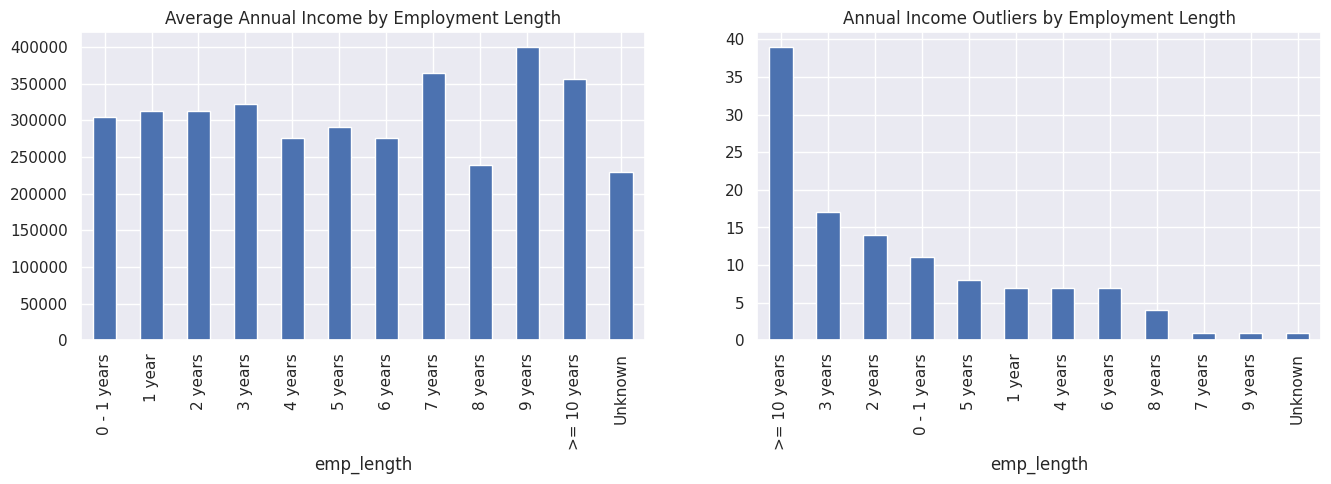

In [ ]:
fig,axss = plt.subplots(1,2, figsize=[16,4])
income.groupby('emp_length')['annual_inc'].mean().plot(kind = 'bar' , title = 'Average Annual Income by Employment Length', ax = axss[0])
income['emp_length'].value_counts().plot(kind = 'bar' , title = 'Annual Income Outliers by Employment Length', ax = axss[1])

In [ ]:
#total account outlier exploration
total_acc = get_outlier_record('total_acc')
df_total_acc = pd.concat([total_acc['total_acc'].describe(percentiles=[0.25,0.5,0.75,0.95]),df['total_acc'].describe([0.25,0.5,0.75,0.95]) ], axis = 1)
df_total_acc.columns = ['total_acc_outliers','total_acc_all_data']
df_total_acc

,total_acc_outliers,total_acc_all_data
count,100.0000,9004.0000
mean,60.0000,22.4386
std,3.6625,11.1465
min,56.0000,3.0000
25%,57.0000,14.0000
50%,59.0000,21.0000
75%,63.0000,29.0000
95%,63.0000,43.0000
max,79.0000,79.0000


In [ ]:
#total_acc by revol_bal outlier vs grand total
df_total_acc = pd.concat([total_acc['revol_bal'].describe(percentiles=[0.25,0.5,0.75,0.95]),df['revol_bal'].describe([0.25,0.5,0.75,0.95]) ], axis = 1)
df_total_acc.columns = ['revol_bal_total_acc_outliers','revol_bal_acc_all_data']
df_total_acc.iloc[:-1]

,revol_bal_total_acc_outliers,revol_bal_acc_all_data
count,100.0000,9004.0000
mean,24824.7600,13658.4161
std,22104.5742,15038.8254
min,722.0000,0.0000
25%,10279.0000,4559.7500
50%,18540.5000,9889.0000
75%,29355.7500,17468.2500
95%,67014.0000,38496.6500


In [ ]:
#open account outlier exploration
open_acc = get_outlier_record('open_acc')
df_open_acc = pd.concat([total_acc['open_acc'].describe(percentiles=[0.25,0.5,0.75,0.95]),df['open_acc'].describe([0.25,0.5,0.75,0.95]) ], axis = 1)
df_open_acc.columns = ['open_acc_outliers','open_acc_all_data']
df_open_acc

,open_acc_outliers,open_acc_all_data
count,100.000,9004.0000
mean,18.140,9.4298
std,5.995,4.2638
min,5.000,2.0000
25%,15.000,6.0000
50%,18.000,9.0000
75%,22.000,12.0000
95%,30.000,17.0000
max,34.000,34.0000


In [ ]:
#open_acc by revol_bal outlier vs grand total
df_open_acc = pd.concat([open_acc['revol_bal'].describe(percentiles=[0.25,0.5,0.75,0.95]),df['revol_bal'].describe([0.25,0.5,0.75,0.95]) ], axis = 1)
df_open_acc.columns = ['revol_bal_total_acc_outliers','revol_bal_acc_all_data']
df_open_acc.iloc[:-1]

,revol_bal_total_acc_outliers,revol_bal_acc_all_data
count,78.0000,9004.0000
mean,22658.6282,13658.4161
std,24676.7114,15038.8254
min,336.0000,0.0000
25%,7721.7500,4559.7500
50%,17026.0000,9889.0000
75%,27265.5000,17468.2500
95%,65101.9000,38496.6500


# Part 2: Data cleaning and Feature Preprocessing


In this session, we imputed missing values and outliers, encoded categorical variables, and dropped unnecessary variables to improve model performance.

## 2.1 Missing Value

We filled missing values of *emp_length* with unknown as a new category.

*revol_util* had only 3 missing values so we can simply impute these with variable mean.



In [ ]:
df['emp_length'] = df['emp_length'].fillna('Unknown')

In [ ]:
df['revol_util'].fillna(df['revol_util'].mean(),inplace = True)

## 2.2 Categorical Variable to Numeric Varaible

For modeling purpose, we encode categorical variables to a set of binary variables.

In [ ]:
# recode emp_length
def recode_emp_length(el):
    if el in ['0 - 1 years','2 years','1 year']:
        return '0 - 2 years'
    elif el in ['3 years','4 years','5 years']:
        return '3 - 5 years'
    elif el in ['6 years','7 years','8 years','9 years']:
        return '6 - 9 years'
    else:
        return el

df['emp_length'] = df['emp_length'].apply(recode_emp_length)

In [ ]:
df_encoded = pd.get_dummies(df,[ 'term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose','addr_state'])

## 2.3 Drop Unneccessary Variables

We included only those variables that did not exhibit high correlation with other variables and would not cause data leakage.

In [ ]:
#drop unneccesary variables
df_encoded = df_encoded.drop(['term_ 60 months','grade_G','home_ownership_OWN',
              'verification_status_Not Verified', 'purpose_other','addr_state_Others','emp_length_Unknown'],axis = 1)

## 2.4 Outlier Imputation

For variables with outliers, we imputed these extreme values using their 99th percentile to minimize their distortion on the candidate machine learning models.

In [ ]:
columns = ['annual_inc', 'revol_bal', 'total_acc','open_acc']  # List of columns to process

for column in columns:
    percentile_99 = df_encoded[column].quantile(0.99)
    df_encoded[column] = df_encoded[column].apply(lambda x: percentile_99 if x > percentile_99 else x)

## 2.5 Data Processing

We divided the data into training and control sets for modeling purposes and standardized the data to improve model performance.

In [ ]:
# split dataset
from sklearn.model_selection import train_test_split

y = df_encoded.loan_status
X = df_encoded.drop(["loan_status"], axis=1)

# Reserve 25% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)
# standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_sd = scaler.transform(X_train)
X_test_sd = scaler.transform(X_test)

Note: Random Forest Classifier and Regressor would use orginal data but not standardized.

# Part 3: Model Training and Selection

## 3.1 Modeling for loan_status

We developed Logistic Regression, RandomForest, Nerual Network models to predict loan status, optimizing for recall to effectively identify defaults.







###3.1.1 Model Fitting & Performance Evaluation

The Random Forest model outperformed the other three models, achieving the highest recall and demonstrating efficient model fitting. It correctly identified 73% of fully paid loans and 65% of defaults.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

# Logistic Regression
classifier_logistic = LogisticRegression()

# Random Forest
classifier_RF = RandomForestClassifier()

#nerual network
mlp = MLPClassifier()

In [ ]:
#logistic modeling
param_grid_logistic = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'],'solver': ['liblinear'], 'class_weight': [None, 'balanced']}
grid_search_logistic = GridSearchCV(classifier_logistic, param_grid_logistic, cv=5, scoring='recall')
grid_search_logistic.fit(X_train_sd, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10], 'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='recall')

In [ ]:
#logistic performance
prediction_Regression = grid_search_logistic.predict(X_test_sd)
print(classification_report(y_test,prediction_Regression))

              precision    recall  f1-score   support

           0       0.92      0.70      0.79      1872
           1       0.32      0.69      0.43       379

    accuracy                           0.70      2251
   macro avg       0.62      0.69      0.61      2251
weighted avg       0.82      0.70      0.73      2251



In [ ]:
grid_search_logistic.best_estimator_

LogisticRegression(C=10, class_weight='balanced', solver='liblinear')

In [ ]:
#RF modeling
#1 minite to train
param_grid_RF = {'n_estimators': [ 50, 100, 200],'max_depth': [5, 6, 7], 'max_features': ['sqrt'],'class_weight': [None, 'balanced']}
grid_search_RF = GridSearchCV(classifier_RF, param_grid_RF, cv=5, scoring='recall')
grid_search_RF.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [5, 6, 7], 'max_features': ['sqrt'],
                         'n_estimators': [50, 100, 200]},
             scoring='recall')

In [ ]:
#RF performance
prediction_RF = grid_search_RF.predict(X_test)
print(classification_report(y_test,prediction_RF))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1872
           1       0.33      0.65      0.44       379

    accuracy                           0.72      2251
   macro avg       0.62      0.69      0.63      2251
weighted avg       0.81      0.72      0.75      2251



In [ ]:
grid_search_RF.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=50)

In [ ]:
#9 minutes to train
# Nerual Netwrok
parameter_grid_mlp = {
    'hidden_layer_sizes': [ (50,50), (100,100),(50,50,50),(100,100,100)],
    'solver': ['sgd', 'adam'],
    'alpha': [0.001, 0.01,0.1],
    'learning_rate': ['adaptive'],
}

mlp = MLPClassifier(max_iter=100)  # You might want to add or adjust other fixed parameters

# Create a GridSearchCV object
grid_search_mlp = GridSearchCV(mlp, parameter_grid_mlp, n_jobs=-1, cv=5)
grid_search_mlp.fit(X_train_sd, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.



GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1],
                         'hidden_layer_sizes': [(50, 50), (100, 100),
                                                (50, 50, 50), (100, 100, 100)],
                         'learning_rate': ['adaptive'],
                         'solver': ['sgd', 'adam']})

In [ ]:
#Nerual Netwrok performance
prediction_mlp = grid_search_mlp.predict(X_test)
print(classification_report(y_test,prediction_RF))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1872
           1       0.33      0.65      0.44       379

    accuracy                           0.72      2251
   macro avg       0.62      0.69      0.63      2251
weighted avg       0.81      0.72      0.75      2251



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names



In [ ]:
grid_search_mlp.best_estimator_

MLPClassifier(alpha=0.1, hidden_layer_sizes=(50, 50, 50),
              learning_rate='adaptive', max_iter=100, solver='sgd')

###3.1.2 Feature Importance

The most influential features for predicting borrower defaults were associated with the loan term, interest rate and if a borrower was grade A.

In [ ]:
# check feature importance of logistics regression
forest_best = RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=50)
forest_best.fit(X, y)

importances = forest_best.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for ind in range(X.shape[1]):
  print ("{0} : {1}".format(X.columns[indices[ind]],round(importances[indices[ind]], 2)))

Feature importance ranking by Random Forest Model:
term_ 36 months : 0.24
int_rate : 0.17
grade_A : 0.13
annual_inc : 0.08
revol_util : 0.07
loan_amnt : 0.04
grade_B : 0.03
grade_D : 0.03
earliest_cr_line : 0.03
dti : 0.03
grade_E : 0.02
total_acc : 0.02
grade_F : 0.02
revol_bal : 0.02
inq_last_6mths : 0.01
purpose_credit_card : 0.01
open_acc : 0.01
purpose_small_business : 0.01
grade_C : 0.01
home_ownership_RENT : 0.01
home_ownership_MORTGAGE : 0.0
purpose_major_purchase : 0.0
addr_state_TX : 0.0
emp_length_3 - 5 years : 0.0
addr_state_CA : 0.0
purpose_house : 0.0
emp_length_>= 10 years : 0.0
emp_length_0 - 2 years : 0.0
addr_state_NY : 0.0
verification_status_Source Verified : 0.0
addr_state_FL : 0.0
pub_rec : 0.0
purpose_debt_consolidation : 0.0
verification_status_Verified : 0.0
purpose_medical : 0.0
emp_length_6 - 9 years : 0.0
addr_state_NJ : 0.0
purpose_car : 0.0


## 3.2 Modeling for interest int_rate

We developed Linear Regression, K-Neighbors Regressor, and RandomForest Regressor models to predict interest rates, focusing on minimizing MSE for more accurate predictions. We excluded records indicating defaults, as these problematic loans may not provide valuable insights for establishing rules for interest rate settings.

### 3.2.1 Model Fitting and Performance Evaluation

Lasso was the best model. The error rate in interest rate prediciton was only 6%.

In [ ]:
# remove defaults
int_df = df_encoded[df_encoded.loan_status == 0]

In [ ]:
y_int = int_df.int_rate
X_int = int_df.drop(["loan_status","int_rate"], axis=1)

# Reserve 25% for testing
X_train_int, X_test_int, y_train_int, y_test_int = train_test_split(X_int, y_int, random_state=42, test_size=.25)

#standardize
scaler.fit(X_train_int)
X_train_sd_int = scaler.transform(X_train_int)
X_test_sd_int = scaler.transform(X_test_int)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso

# Linear Regression
regressor_lasso = Lasso()

# K Nearest Neighbors Regressor
regressor_KNN = KNeighborsRegressor()

# Random Forest Regressor
regressor_RF = RandomForestRegressor()

In [ ]:
#logistic modeling
param_grid_lasso = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search_lasso = GridSearchCV(Lasso(), param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train_sd_int, y_train_int)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [ ]:
# get absolute interest error rate lasso
round(sum(abs(y_test_int- grid_search_lasso.predict(X_test_sd_int) ))/sum(y_test_int),2)

0.06

In [ ]:
#KNN
param_grid_KNN = {'n_neighbors': [5,7,9,11],  # Test different neighbors
    'weights': ['uniform', 'distance'],  # Test uniform and distance weights
    'metric': ['euclidean', 'manhattan', 'minkowski']}  # Test different distance metrics}
grid_search_KNN  = GridSearchCV(regressor_KNN,param_grid_KNN, cv=5, scoring='neg_mean_squared_error')
grid_search_KNN.fit(X_train_sd_int, y_train_int)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [ ]:
# get absolute interest error rate KNN
round(sum(abs(y_test_int - grid_search_KNN.predict(X_test_sd_int) ))/sum(y_test_int),2)

0.08

In [ ]:
param_grid_RF = {'n_estimators': [ 50, 100, 200],'max_depth': [5, 6, 7], 'max_features': ['sqrt']}
grid_search_RF = GridSearchCV(regressor_RF, param_grid_RF, cv=5, scoring='neg_mean_squared_error')
grid_search_RF.fit(X_train_int, y_train_int)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 6, 7], 'max_features': ['sqrt'],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [ ]:
# get absolute interest error rate KNN
round(sum(abs(y_test_int - grid_search_RF.predict(X_test_sd_int) ))/sum(y_test_int),2)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



0.09

### 3.2.2 Feature Importance

Borrower's grade largely determine the interest rate for the loan. The higher the grade, the lower the interest rate.

In [ ]:
best_lasso = grid_search_lasso.best_estimator_
lasso_coefficients = best_lasso.coef_
feature_coefficients = pd.DataFrame({
    'Feature': X_train_int.columns,
    'Coefficient': lasso_coefficients
})

# Display the DataFrame sorted by the absolute value of coefficients in descending order
print(feature_coefficients.sort_values(by='Coefficient', key=abs, ascending=False))

                                Feature  Coefficient
11                              grade_A      -6.5477
12                              grade_B      -4.7363
13                              grade_C      -2.7821
14                              grade_D      -1.4479
15                              grade_E      -0.6231
8                            revol_util       0.3048
10                      term_ 36 months      -0.2020
4                        inq_last_6mths       0.1238
16                              grade_F      -0.1143
3                      earliest_cr_line       0.0933
5                              open_acc       0.0763
0                             loan_amnt       0.0734
6                               pub_rec       0.0613
9                             total_acc      -0.0584
24         verification_status_Verified       0.0522
17               emp_length_0 - 2 years       0.0404
7                             revol_bal      -0.0385
21              home_ownership_MORTGAGE      -

# Part 5 : Summary

This project focused on predicting loan defaults and interest rates for LendingClub's small loans to enhance its risk management and profitability. LendingClub has been grappling with a high default rate of 17% and a significant loss of 43% on defaulted loans for the small loan business, likely due to its aggressive loan issuance strategy. Notably, 40% of its loans are issued to borrowers <= grade C for nearly the full amount requested, and over 50% of small loan borrowers have issues with overspending.

The raw data was relatively clean. Only 4 variables had 1-2% outliers, which could be validated as genuine through cross-validation with other variables. Additionally, 3% of the records had missing values, primarily in the revolving line utilization rate and employment length.

To optimize model performance, we implemented several strategies: imputing missing values with the average or a new class, capping outliers at the 99th percentile, encoding categorical variables, removing variables that could cause data leakage or were highly correlated with other variables, and standardizing data when necessary.

In terms of default predictions, the Random Forest model had the best performance, correctly identifying 73% of fully-paid loans and 65% of defaults. The most critical features influencing borrower defaults were loan term and interest rate and borrower's grade.

For predicting interest rates, Lasso regression was most effective, demonstrating a low error rate of 6%. This strong model performance was likely due to the significant influence of borrowers' credit grade on interest rates.

# Part 6 : Future improvement

1. To enhance the performance of default prediction models, we could weight the sample defaulted based on the potential profit loss from incorrect predictions of defaults vs fully-paid, rather than merely weighting by the its sample size vs that of fully-paid.

2. Instead of merely modeling whether a loan defaults, we could focus on predicting the total payment LendingClub will receive. This approach would provide insights into whether to issue the full or partial loan amount to minimize risk.

3. For interest rate predictions, considering only non-defaulting records might yield more conservative results. To optimize interest rates, we could employ the *optimization* module in *scipy*, applying reasonable constraints on the risk premium to maximize loan payments.